# Project 2 - Finance

### DESCRIPTION

#### Problem Statement
- Finance Industry is the biggest consumer of Data Scientists. It faces constant attack by fraudsters, who try to trick the system. Correctly identifying fraudulent transactions is often compared with finding needle in a haystack because of the low event rate. 
- It is important that credit card companies are able to recognize fraudulent credit card transactions so that the customers are not charged for items that they did not purchase.
You are required to try various techniques such as supervised models with oversampling, unsupervised anomaly detection, and heuristics to get good accuracy at fraud detection.

#### Dataset Snapshot

The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset represents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

### Project Task: Week 1

#### Exploratory Data Analysis (EDA):
- Perform an EDA on the Dataset.
      - Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean) with unit standard deviation
      - Find if there is any connection between Time, Amount, and the transaction being fraudulent.
- Check the class count for each class. It’s a class Imbalance problem.
- Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.
       - Oversampling or undersampling can be used to tackle the class imbalance problem
       - Oversampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.
- Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [1]:
!pip install matplotlib
!python -m pip install seaborn
!pip install -U imbalanced-learn
!pip install delayed
!pip install xgboost

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import copy
import time
import sys
from datetime import datetime

from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [3]:
# read data
df_train_original = pd.read_csv('./dataset/train_data.csv')
df_test_original = pd.read_csv('./dataset/test_data_hidden.csv')
# df_test_original = pd.read_csv('./dataset/test_data.csv')

In [4]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

In [5]:
print(df_train.shape)
print(df_test.shape)

(49820, 31)
(51731, 31)


In [6]:
df_train.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,38355.0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,...,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894,49.67,0.0
1,22555.0,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,...,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086,16.94,0.0
2,2431.0,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,...,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623,1.00,0.0
3,86773.0,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,...,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635,10.78,0.0
4,127202.0,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,...,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888,39.96,0.0


In [7]:
df_test.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,113050.0,0.114697,0.796303,-0.149553,-0.823011,0.878763,-0.553152,0.939259,-0.108502,0.111137,...,-0.335776,-0.807853,-0.055940,-1.025281,-0.369557,0.204653,0.242724,0.085713,0.89,0.0
1,26667.0,-0.039318,0.495784,-0.810884,0.546693,1.986257,4.386342,-1.344891,-1.743736,-0.563103,...,-1.377003,-0.072200,-0.197573,1.014807,1.011293,-0.167684,0.113136,0.256836,85.00,0.0
2,159519.0,2.275706,-1.531508,-1.021969,-1.602152,-1.220329,-0.462376,-1.196485,-0.147058,-0.950224,...,-0.193271,-0.103533,0.150945,-0.811083,-0.197913,-0.128446,0.014197,-0.051289,42.70,0.0
3,137545.0,1.940137,-0.357671,-1.210551,0.382523,0.050823,-0.171322,-0.109124,-0.002115,0.869258,...,0.157994,0.650355,0.034206,0.739535,0.223605,-0.195509,-0.012791,-0.056841,29.99,0.0
4,63369.0,1.081395,-0.502615,1.075887,-0.543359,-1.472946,-1.065484,-0.443231,-0.143374,1.659826,...,0.224157,0.821209,-0.137223,0.986259,0.563228,-0.574206,0.089673,0.052036,68.00,0.0


In [8]:
# Rows containing train duplicate data
duplicate_rows_df_train = df_train[df_train.duplicated()]
print("number of duplicate train rows: ", duplicate_rows_df_train.shape)

number of duplicate train rows:  (45, 31)


In [9]:
# Rows containing test duplicate data
duplicate_rows_df_train = df_test[df_test.duplicated()]
print("number of duplicate test rows: ", duplicate_rows_df_train.shape)

number of duplicate test rows:  (35, 31)


In [10]:
# Remove duplicate entires
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [11]:
print(df_train.shape)
print(df_test.shape)

(49775, 31)
(51696, 31)


#### 1.a Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean)

In [12]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,49775.0,94982.460593,47587.599737,1.000000,54272.500000,84999.000000,139695.500000,172788.000000
V1,49775.0,-0.018686,2.011125,-46.855047,-0.926589,0.003073,1.316281,2.406284
V2,49775.0,-0.011404,1.709330,-63.344698,-0.606529,0.057337,0.805030,22.057729
V3,49775.0,-0.005354,1.548371,-31.813586,-0.889742,0.176664,1.032670,4.029428
V4,49775.0,0.004637,1.432208,-5.416315,-0.857632,-0.017937,0.751129,16.715537
V5,49775.0,-0.008664,1.382881,-42.147898,-0.701238,-0.062255,0.599577,29.162172
V6,49775.0,0.006113,1.330202,-20.367836,-0.767659,-0.272083,0.405894,22.529298
V7,49775.0,-0.008490,1.253202,-43.557242,-0.562308,0.033625,0.564746,36.677268
V8,49775.0,0.002226,1.249907,-73.216718,-0.207571,0.024914,0.333363,17.941363
V9,49775.0,0.000042,1.114440,-13.320155,-0.654103,-0.052561,0.603923,10.392889


#### 1.b Find if there is any connection between Time, Amount, and the transaction being fraudulent.

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Time ditributions'}, xlabel='Time', ylabel='Density'>

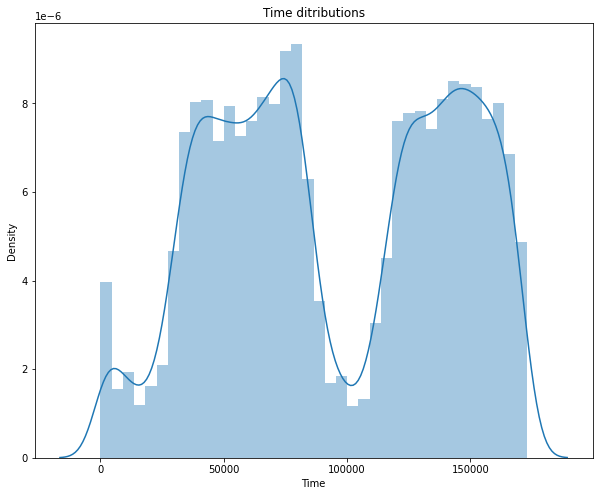

In [13]:
# visualizations of time
plt.figure(figsize=(10,8))
plt.title("Time ditributions")
sns.distplot(df_train.Time)

In [14]:
# The time inseconds need to converts
df_train['Time'] = df_train['Time'] / 3600
# df_train_original['Time'] = df_train_original['Time'] / 24
print(df_train['Time'].min())
print(df_train['Time'].max())

0.0002777777777777778
47.99666666666667


/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Transaction Times')

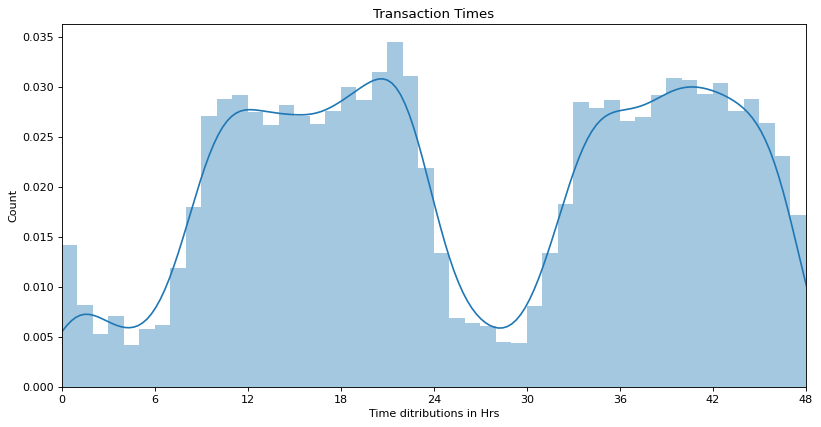

In [15]:
plt.figure(figsize=(12,6), dpi=80)
sns.distplot(df_train.Time, bins=48)
plt.xlim([0,48])
plt.xticks(np.arange(0,54,6))
plt.xlabel('Time ditributions in Hrs')
plt.ylabel('Count')
plt.title('Transaction Times')

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Time ditributions'}, xlabel='Amount', ylabel='Density'>

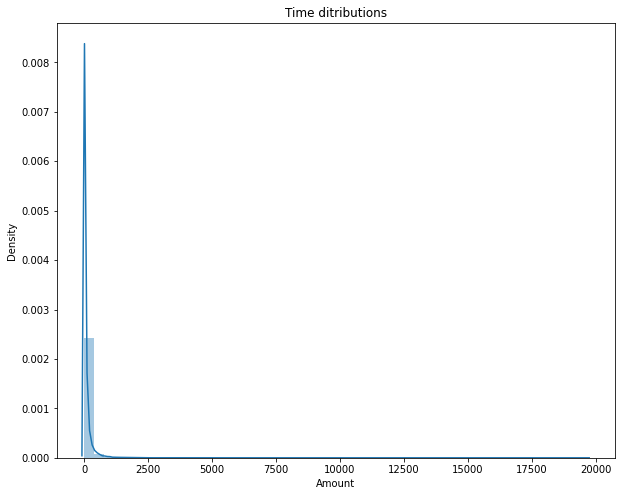

In [16]:
# visualizations of amount
plt.figure(figsize=(10,8))
plt.title("Time ditributions")
sns.distplot(df_train.Amount)

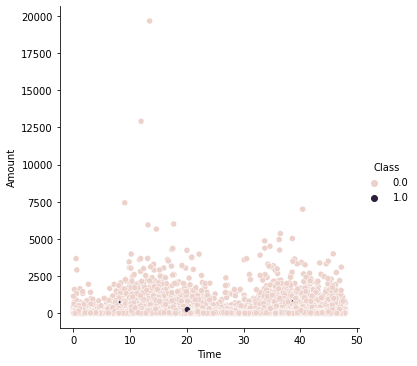

In [17]:
sns.relplot(x="Time", y="Amount", hue="Class", data=df_train);

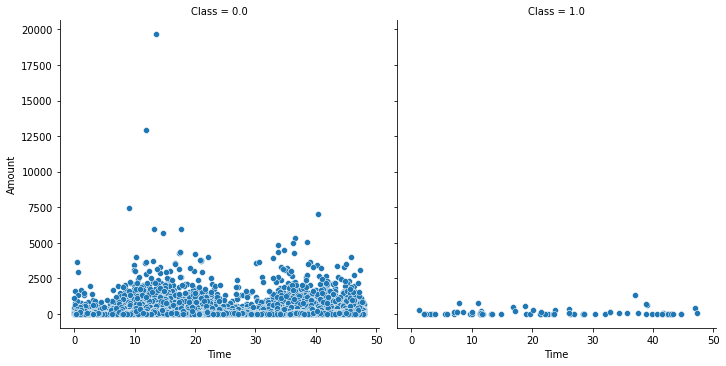

In [18]:
sns.relplot(x="Time", y="Amount", col="Class", data=df_train);

####   2.Check the class count for each class. It’s a class Imbalance problem.

In [19]:
df_train['Class'].value_counts()

0.0    49688
1.0       86
Name: Class, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='count'>

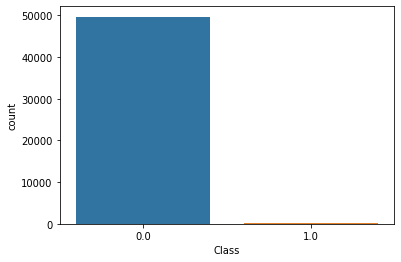

In [20]:
sns.countplot('Class', data=df_train)

#### 3.Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.

In [21]:
robust_scaler = RobustScaler()

df_train['scaled_amount'] = robust_scaler.fit_transform(df_train['Amount'].values.reshape(-1,1))
df_train['scaled_time'] = robust_scaler.fit_transform(df_train['Time'].values.reshape(-1,1))

df_test['scaled_amount'] = robust_scaler.fit_transform(df_test['Amount'].values.reshape(-1,1))
df_test['scaled_time'] = robust_scaler.fit_transform(df_test['Time'].values.reshape(-1,1))

In [22]:
# Remove the Time,Amount 
df_train.drop(['Time','Amount'], axis=1, inplace=True)
df_test.drop(['Time','Amount'], axis=1, inplace=True)

In [23]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [24]:
y_train = df_train.pop('Class')
X_train = df_train

In [25]:
print(y_train.shape)
print(X_train.shape)

(49774,)
(49774, 30)


In [26]:
y_test = df_test.pop('Class')
X_test = df_test
print(X_test.shape)
print(y_test.shape)

(51695, 30)
(51695,)


In [27]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,49774.0,-0.018659,2.011137,-46.855047,-0.926545,0.003188,1.316292,2.406284
V2,49774.0,-0.011408,1.709347,-63.344698,-0.606529,0.057305,0.805040,22.057729
V3,49774.0,-0.005399,1.548354,-31.813586,-0.889746,0.176599,1.032617,4.029428
V4,49774.0,0.004657,1.432215,-5.416315,-0.857526,-0.017884,0.751157,16.715537
V5,49774.0,-0.008641,1.382885,-42.147898,-0.701170,-0.062236,0.599594,29.162172
V6,49774.0,0.006123,1.330214,-20.367836,-0.767667,-0.272063,0.405904,22.529298
V7,49774.0,-0.008480,1.253212,-43.557242,-0.562314,0.033627,0.564765,36.677268
V8,49774.0,0.002214,1.249916,-73.216718,-0.207577,0.024904,0.333330,17.941363
V9,49774.0,0.000063,1.114442,-13.320155,-0.654096,-0.052557,0.603927,10.392889
V10,49774.0,0.005840,1.113391,-24.588262,-0.534072,-0.086148,0.464616,13.727347


In [28]:
# oversampling tarin data
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

print(X_train_over.shape)
print(y_train_over.shape)

(99376, 30)
(99376,)


In [29]:
# undersampling tarin data
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(X_train_under.shape)
print(y_train_under.shape)

(172, 30)
(172,)


In [30]:
def modal_perfomance(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    predicted = model.predict(X_test)
    report = classification_report(Y_test, predicted)
    print("f1_score       : ", f1_score(Y_test, predicted, average="macro"))
    print("precision_score: ", precision_score(Y_test, predicted, average="macro"))
    print("recall_score   : ", recall_score(Y_test, predicted, average="macro"))
    print("\nAccuracy Score :",accuracy_score(predicted, Y_test))
    print(report)
    plot_roc_curve(model, X_test, Y_test)  
    plt.show() 
#     roc_curve_plt(model, X_test, Y_test, predicted)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


f1_score       :  0.5428535152028675
precision_score:  0.5264447353448544
recall_score   :  0.9266940974614221

Accuracy Score : 0.9715059483509043
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     51602
         1.0       0.05      0.88      0.10        93

    accuracy                           0.97     51695
   macro avg       0.53      0.93      0.54     51695
weighted avg       1.00      0.97      0.98     51695



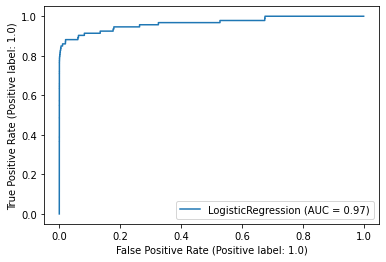

In [31]:
lr = LogisticRegression(class_weight ='balanced')
modal_perfomance(lr, X_train_over, y_train_over, X_test, y_test)

### Observations: Week 1
- Traing set contains two days transaction details, the rate transaction low at night times
- The amount of transcation is highy skewed distribution, only low number count detected for high amount transcation
- There is no connection between Time, Amount, and the transaction being fraudulent
- All the fraudulent transactions are low amount
- This is highly class Imbalance problem, fraudulent transaction are very rare less than 0.17 %

### Project Task: Week 2

#### Modeling Techniques:
- Try out models like Naive Bayes, Logistic Regression or SVM. Find out which one performs the best
- Use different Tree-based classifiers like Random Forest and XGBoost. 
       a.    Remember Tree-based classifiers work on two ideologies: Bagging or Boosting
       b.    Tree-based classifiers have fine-tuning parameters which takes care of the imbalanced class. Random-Forest and XGBboost.
- Compare the results of 1 with 2 and check if there is any incremental gain.

In [32]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

df_train.drop(['Time','Amount'], axis=1, inplace=True)
df_test.drop(['Time','Amount'], axis=1, inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

y_train = df_train.pop('Class')
X_train = df_train
y_test = df_test.pop('Class')
X_test = df_test

In [33]:
# Create logistic regression pipeline
lr_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()), 
        ('lr', LogisticRegression(n_jobs = -1, verbose=2))
    ]
)

In [34]:
# Create SVC pipeline
svm_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()), 
        ('svm', SVC(verbose=2))
    ]
)

In [35]:
# Create Gaussian NB pipeline
gnb_pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()), 
        ('gnb', GaussianNB())
    ]
)

In [36]:
pipelines = [
    lr_pipeline, 
    svm_pipeline, 
    gnb_pipeline
]

In [37]:
pipeline_dict = {
    0 : 'LogisticRegression',
    1 : 'SVM',
    2 : 'Gaussian NB'
}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished


[LibSVM]

In [38]:
# finding best modal
for i,modal in enumerate(pipelines):
    print("{} Test accuracy {}".format(pipeline_dict[i], modal.score(X_test, y_test)))

LogisticRegression Test accuracy 0.9989367871641214
SVM Test accuracy 0.9990721051614151
Gaussian NB Test accuracy 0.9799922675430118


In [39]:
def tree_perfomace_tracker(modal, X_test, y_test ):
    predict = modal.predict(X_test)
    cf_matrix = confusion_matrix(predict, y_test)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='')

    print("Accuracy Score :",accuracy_score(predict, y_test))
    print("f1_score       : ", f1_score(predict, y_test))
    

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy Score : 0.9993427411560023
f1_score       :  0.7763157894736843


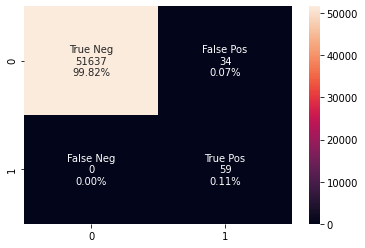

In [40]:
# RAndom Forest
rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
tree_perfomace_tracker(rf, X_test, y_test)

/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy Score : 0.9991687608737676
f1_score       :  0.7225806451612904


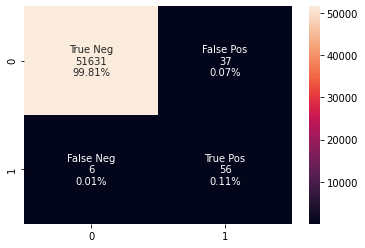

In [41]:
# Xg Boost
xb = xgb.XGBClassifier(learning_rate=0.001, n_jobs=-1)
xb.fit(X_train, y_train, eval_metric='logloss', verbose=True)
tree_perfomace_tracker(xb, X_test, y_test)

Accuracy Score : 0.9991494297312972
f1_score       :  0.6901408450704225


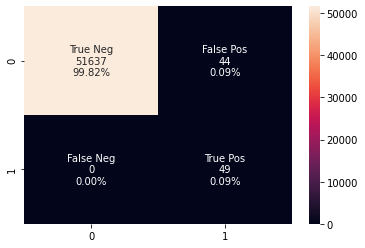

In [42]:
# Bagging Classifire
BC_clf = BaggingClassifier(base_estimator=SVC(), random_state=0, n_jobs=-1)
BC_clf.fit(X_train, y_train)
tree_perfomace_tracker(BC_clf, X_test, y_test)

Accuracy Score : 0.9993427411560023
f1_score       :  0.782051282051282


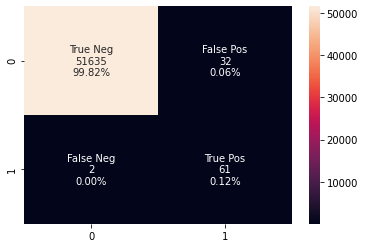

In [43]:
# Bagging Classifire
BC_RFC = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced_subsample'),  n_jobs=-1)
BC_RFC.fit(X_train, y_train)
tree_perfomace_tracker(BC_RFC, X_test, y_test)

Accuracy Score : 0.9991300985888266
f1_score       :  0.6979865771812079


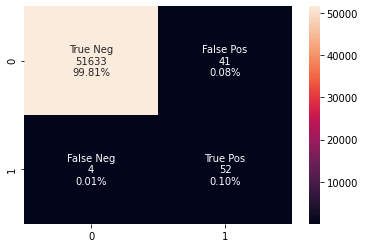

In [44]:
# Gradient Classifire
GBC = GradientBoostingClassifier(random_state=0, loss='deviance', learning_rate=0.01, criterion='mse')
GBC.fit(X_train, y_train)
tree_perfomace_tracker(GBC,  X_test, y_test)

Accuracy Score : 0.9993040788710613
f1_score       :  0.76


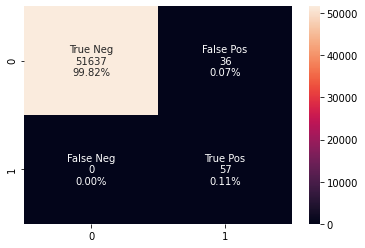

In [45]:
# Extra Classifire
ETC = ExtraTreesClassifier(n_estimators=100, random_state=0, class_weight='balanced', n_jobs = 6)
ETC.fit(X_train, y_train)
tree_perfomace_tracker(ETC, X_test, y_test)

Accuracy Score : 0.9992267543011792
f1_score       :  0.7402597402597403


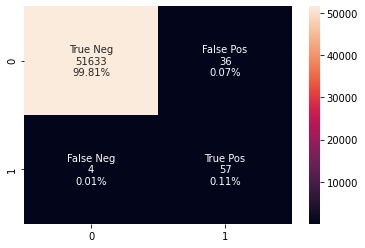

In [46]:
# Ada boost Classifire
ADC = AdaBoostClassifier(n_estimators=100, random_state=0)
ADC.fit(X_train, y_train)
tree_perfomace_tracker(ADC, X_test, y_test)

### Observations: Week 2
- Compare Logistic, SVM the essembles method had more incremental gain.
- RandomForestClassifier Bagging classifire outperfome compare to other modals
- Computation wise EtraTreeClassifire is the better one and a little downwards

### Project Task: Week 3

#### Applying ANN:
- Use ANN (Artificial Neural Network) to identify fradulent and non-fradulent.
       a)    Fine-tune number of layers
       b)    Number of Neurons in each layers
       c)    Experiment in batch-size
       d)    Experiment with number of epochs. Check the observations in loss and accuracy
       e)    Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
       f)    Find out which activation performs best for this use case and why?
       g)    Check Confusion Matrix, Precision, Recall and F1-Score
- Try out Dropout for ANN. How is it performed? Compare model performance with the traditional ML based prediction models from above. 
- Find the best setting of neural net that can be best classified as fraudulent and non-fraudulent transactions. Use techniques like Grid Search, Cross-Validation and Random search.

##### Anomaly Detection:
- Implement anomaly detection algorithms.
        a)    Assume that the data is coming from a single or a combination of multivariate Gaussian
        b)    Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in a)

In [47]:
df_train.head(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,0.499167,...,-0.720944,-0.084556,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894
1,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,-0.658751,...,1.325588,-0.373759,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086
2,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,-1.109522,...,0.095583,-0.039868,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623
3,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,0.154307,...,0.136148,0.382305,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635
4,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,0.428729,...,1.064984,0.106592,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888


In [48]:
def model_building(optimizer='Adam', learn_rate = 0.01, dropout_rate = 0.2):
    model = Sequential()
    model.add(Dense(input_dim = 28, units = 256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units =  512 , activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 114, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 56, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units =1, activation = 'sigmoid'))    
    
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC()])
    return model

In [49]:
model_building().summary()

[2021-06-21 17:32:56.294 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:187 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-21 17:32:56.320 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:187 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7424      
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_____________________

In [50]:
# tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_building().compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# print(os.getcwd())
logdir="logs/fit/"+ datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model_building().fit(X_train, y_train, epochs=10, batch_size=45, validation_data=(X_test, y_test))

Epoch 1/10
1108/1108 [==============================] - 7s 6ms/step - loss: 0.0108 - accuracy: 0.9981 - auc_2: 0.8776 - val_loss: 0.0050 - val_accuracy: 0.9994 - val_auc_2: 0.9031
Epoch 2/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0059 - accuracy: 0.9990 - auc_2: 0.9195 - val_loss: 0.0045 - val_accuracy: 0.9994 - val_auc_2: 0.9188
Epoch 3/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0040 - accuracy: 0.9992 - auc_2: 0.9484 - val_loss: 0.0049 - val_accuracy: 0.9993 - val_auc_2: 0.9233
Epoch 4/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0045 - accuracy: 0.9991 - auc_2: 0.9370 - val_loss: 0.0049 - val_accuracy: 0.9994 - val_auc_2: 0.9487
Epoch 5/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0045 - accuracy: 0.9991 - auc_2: 0.9370 - val_loss: 0.0047 - val_accuracy: 0.9984 - val_auc_2: 0.9349
Epoch 6/10
1108/1108 [==============================] - 6s 6ms/step - loss: 0.0041 - accuracy: 0.999

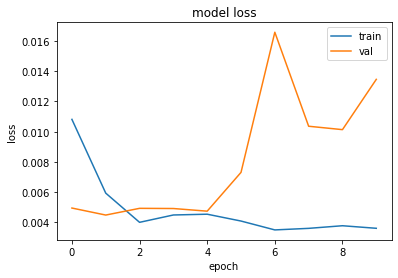

In [52]:
# Experiment with number of epochs. Check the observations in loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

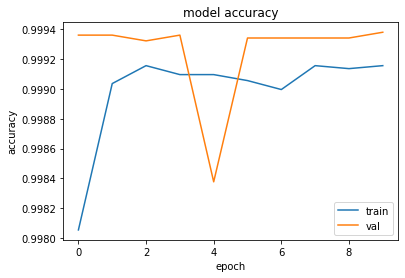

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [58]:
ann_modal = KerasClassifier(build_fn=model_building, epochs=30)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
learn_rate = [0.01, 0.02, 0.2]
dropout_rate = [0.0, 0.1, 0.2, 0.4]
param_grid = dict(batch_size=batch_size, epochs=epochs,learn_rate=learn_rate, dropout_rate=dropout_rate)

#### RandamSearch

In [59]:
grid = RandomizedSearchCV(estimator=ann_modal, param_distributions =param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning


Epoch 1/50
1246/1246 [==============================] - 8s 6ms/step - loss: 0.0164 - accuracy: 0.9971 - auc_5: 0.8042 - val_loss: 0.0053 - val_accuracy: 0.9993 - val_auc_5: 0.9026
Epoch 2/50
1246/1246 [==============================] - 7s 6ms/step - loss: 0.0077 - accuracy: 0.9988 - auc_5: 0.9190 - val_loss: 0.0058 - val_accuracy: 0.9993 - val_auc_5: 0.8868
Epoch 3/50
1246/1246 [==============================] - 7s 6ms/step - loss: 0.0064 - accuracy: 0.9990 - auc_5: 0.9255 - val_loss: 0.0063 - val_accuracy: 0.9994 - val_auc_5: 0.8869
Epoch 4/50
1246/1246 [==============================] - 7s 6ms/step - loss: 0.0053 - accuracy: 0.9991 - auc_5: 0.9309 - val_loss: 0.0046 - val_accuracy: 0.9993 - val_auc_5: 0.9347
Epoch 5/50
1246/1246 [==============================] - 7s 6ms/step - loss: 0.0054 - accuracy: 0.9991 - auc_5: 0.9369 - val_loss: 0.0053 - val_accuracy: 0.9994 - val_auc_5: 0.9182
Epoch 6/50
1246/1246 [==============================] - 7s 6ms/step - loss: 0.0049 - accuracy: 0.998

In [60]:
print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: nan using {'learn_rate': 0.2, 'epochs': 50, 'dropout_rate': 0.4, 'batch_size': 40}


#### Cross-Validation

In [61]:
scores = cross_val_score(ann_modal, X_train, y_train, cv=5, scoring='f1')
print("f1 score is: ", scores.mean())

Epoch 1/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0108 - accuracy: 0.9977 - auc_6: 0.8787
Epoch 2/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0055 - accuracy: 0.9990 - auc_6: 0.9162
Epoch 3/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0061 - accuracy: 0.9991 - auc_6: 0.9022
Epoch 4/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0050 - accuracy: 0.9990 - auc_6: 0.9230
Epoch 5/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0048 - accuracy: 0.9992 - auc_6: 0.9438
Epoch 6/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0060 - accuracy: 0.9989 - auc_6: 0.9439
Epoch 7/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0057 - accuracy: 0.9991 - auc_6: 0.9442
Epoch 8/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0047 - accuracy: 0.9991 - auc_6: 0.9307
Epoch 9/30
1246/1246 [==============================] - 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Epoch 1/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0105 - accuracy: 0.9985 - auc_7: 0.8555
Epoch 2/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0052 - accuracy: 0.9990 - auc_7: 0.9104
Epoch 3/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0052 - accuracy: 0.9989 - auc_7: 0.9251
Epoch 4/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0048 - accuracy: 0.9988 - auc_7: 0.9182
Epoch 5/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0042 - accuracy: 0.9989 - auc_7: 0.9698
Epoch 6/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0059 - accuracy: 0.9990 - auc_7: 0.9476
Epoch 7/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0036 - accuracy: 0.9990 - auc_7: 0.9627
Epoch 8/30
1246/1246 [==============================] - 5s 4ms/step - loss: 0.0034 - accuracy: 0.9990 - auc_7: 0.9774
Epoch 9/30
1246/1246 [==============================] - 

In [62]:
# Experiment in batch-size
batch_size = [10, 20, 40, 60, 80, 100]
param_grid = dict(batch_size = batch_size)
grid = GridSearchCV(estimator = ann_modal, param_grid = param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train,validation_data=(X_test, y_test))
print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  category=UserWarning


Epoch 1/30
4982/4982 [==============================] - 27s 6ms/step - loss: 0.0147 - accuracy: 0.9986 - auc_11: 0.8627 - val_loss: 0.0139 - val_accuracy: 0.9982 - val_auc_11: 0.8118
Epoch 2/30
4982/4982 [==============================] - 27s 5ms/step - loss: 0.0110 - accuracy: 0.9988 - auc_11: 0.8913 - val_loss: 0.0125 - val_accuracy: 0.9987 - val_auc_11: 0.8709
Epoch 3/30
4982/4982 [==============================] - 27s 5ms/step - loss: 0.0115 - accuracy: 0.9987 - auc_11: 0.8971 - val_loss: 0.0158 - val_accuracy: 0.9990 - val_auc_11: 0.8440
Epoch 4/30
4982/4982 [==============================] - 27s 5ms/step - loss: 0.0097 - accuracy: 0.9988 - auc_11: 0.8972 - val_loss: 0.0167 - val_accuracy: 0.9993 - val_auc_11: 0.8655
Epoch 5/30
4982/4982 [==============================] - 27s 5ms/step - loss: 0.0109 - accuracy: 0.9986 - auc_11: 0.9028 - val_loss: 0.0314 - val_accuracy: 0.9992 - val_auc_11: 0.8728
Epoch 6/30
4982/4982 [==============================] - 27s 5ms/step - loss: 0.0099 -

In [63]:
#  Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
optimizers = ['SGD', 'RMSprop', 'Adam']
param_grid = dict(optimizer=optimizers)
grid = GridSearchCV(estimator = ann_modal, param_grid = param_grid, n_jobs = -1, cv = 3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))
print("Best optimizers With Best score: ",grid_result.best_score_, grid_result.best_params_)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  category=UserWarning


Epoch 1/30
1557/1557 [==============================] - 9s 6ms/step - loss: 0.0201 - accuracy: 0.9972 - auc_12: 0.7501 - val_loss: 0.0049 - val_accuracy: 0.9993 - val_auc_12: 0.8921
Epoch 2/30
1557/1557 [==============================] - 9s 6ms/step - loss: 0.0053 - accuracy: 0.9988 - auc_12: 0.9118 - val_loss: 0.0045 - val_accuracy: 0.9993 - val_auc_12: 0.9083
Epoch 3/30
1557/1557 [==============================] - 9s 6ms/step - loss: 0.0041 - accuracy: 0.9991 - auc_12: 0.9303 - val_loss: 0.0043 - val_accuracy: 0.9993 - val_auc_12: 0.9244
Epoch 4/30
1557/1557 [==============================] - 9s 6ms/step - loss: 0.0042 - accuracy: 0.9991 - auc_12: 0.9308 - val_loss: 0.0039 - val_accuracy: 0.9993 - val_auc_12: 0.9297
Epoch 5/30
1557/1557 [==============================] - 9s 6ms/step - loss: 0.0040 - accuracy: 0.9992 - auc_12: 0.9361 - val_loss: 0.0036 - val_accuracy: 0.9993 - val_auc_12: 0.9350
Epoch 6/30
1557/1557 [==============================] - 9s 6ms/step - loss: 0.0038 - accur

#### Perfomace Evalution

Accuracy Score : 0.8842257877440557
f1_score       :  0.0029965040785749956


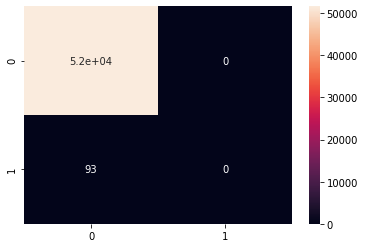

In [64]:
# ann_predictions = model_building().predict(X_test)
ann_predictions = model_building().predict(X_test, verbose=0)
yhat_classes = model_building().predict_classes(X_test, verbose=0)
yhat_probs = ann_predictions[:, 0]
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)

cm = tf.math.confusion_matrix(labels=y_test, predictions=ann_predictions, num_classes=2)
sns.heatmap(cm, annot=True)

print("Accuracy Score :", accuracy)
print("f1_score       : ", f1)

#### After Optimization

In [ ]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

df_train.drop(['Time','Amount'], axis=1, inplace=True)
df_test.drop(['Time','Amount'], axis=1, inplace=True)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

y_train = df_train.pop('Class')
X_train = df_train
y_test = df_test.pop('Class')
X_test = df_test

# oversampling tarin data
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

In [77]:
model = model_building("SGD", 0.2, 0.4)

logdir="logs/fit/"+ datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/10
4982/4982 [==============================] - 26s 5ms/step - loss: 0.0160 - accuracy: 0.9976 - auc_22: 0.7330 - val_loss: 0.0046 - val_accuracy: 0.9986 - val_auc_22: 0.8867
Epoch 2/10
4982/4982 [==============================] - 26s 5ms/step - loss: 0.0062 - accuracy: 0.9985 - auc_22: 0.9271 - val_loss: 0.0043 - val_accuracy: 0.9993 - val_auc_22: 0.9135
Epoch 3/10
4982/4982 [==============================] - 26s 5ms/step - loss: 0.0058 - accuracy: 0.9987 - auc_22: 0.9240 - val_loss: 0.0042 - val_accuracy: 0.9993 - val_auc_22: 0.9349
Epoch 4/10
4982/4982 [==============================] - 26s 5ms/step - loss: 0.0046 - accuracy: 0.9989 - auc_22: 0.9357 - val_loss: 0.0049 - val_accuracy: 0.9993 - val_auc_22: 0.9137
Epoch 5/10
4982/4982 [==============================] - 26s 5ms/step - loss: 0.0037 - accuracy: 0.9989 - auc_22: 0.9536 - val_loss: 0.0050 - val_accuracy: 0.9993 - val_auc_22: 0.8923
Epoch 6/10
4982/4982 [==============================] - 26s 5ms/step - loss: 0.0038 -

Accuracy Score : 0.9993427411560023
f1_score       :  0.8068181818181818


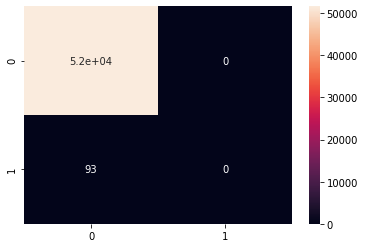

In [78]:
# ann_predictions = model_building().predict(X_test)
ann_predictions = model.predict(X_test, verbose=0)
yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_probs = ann_predictions[:, 0]
yhat_classes = yhat_classes[:, 0]

accuracy = accuracy_score(y_test, yhat_classes)
f1 = f1_score(y_test, yhat_classes)

cm = tf.math.confusion_matrix(labels=y_test, predictions=ann_predictions, num_classes=2)
sns.heatmap(cm, annot=True)

print("Accuracy Score :", accuracy)
print("f1_score       : ", f1)

#### Anomaly Detection:

In [65]:
df_train = copy.deepcopy(df_train_original)
df_test = copy.deepcopy(df_test_original)

fraud = df_train[df_train['Class'] == 1]
valid = df_train[df_train['Class'] == 0]
outlier_fraction = len(fraud) / float(len(valid))
n_outliers = len(fraud)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

y_train = df_train.pop('Class')
X_train = df_train

In [66]:

classifiers = {
    "Isolation Forest" : IsolationForest(
        n_estimators = 100, 
        max_samples = len(X_train), 
        contamination = outlier_fraction,
        random_state = 1, 
        verbose = 1,
        n_jobs = -1
    ),
    "Local Outlier Factor" : LocalOutlierFactor(
        n_neighbors=20, 
        algorithm='auto', 
        leaf_size=30, 
        metric='minkowski',
        p=2, metric_params = None, 
        contamination = outlier_fraction,
        n_jobs = -1
    )   
}

In [67]:

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name, n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_train, y_pred))
    print("Classification Report :")
    print(classification_report(y_train, y_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished


Isolation Forest: 113
Accuracy Score :
0.9977317890764568
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     49730
         1.0       0.37      0.37      0.37        89

    accuracy                           1.00     49819
   macro avg       0.68      0.68      0.68     49819
weighted avg       1.00      1.00      1.00     49819

Local Outlier Factor: 177
Accuracy Score :
0.9964471386418836
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     49730
         1.0       0.01      0.01      0.01        89

    accuracy                           1.00     49819
   macro avg       0.50      0.50      0.50     49819
weighted avg       1.00      1.00      1.00     49819



### Observations: Week 3
- After fine tuning this is the best combination of hyperparsm learn_rate: 0.2, epochs: 50, dropout_rate: 0.4, batch_size: 40, optimization: SGD
- ANN oupperfome most, with more than 99% accuracy and 80% of f1 score
- In terms of Anomaly Detection Isolation Forest is better compare to Local Outlier Factor

### Project Task: Week 4
- Visualize the scores for Fraudulent and Non-Fraudulent transactions.
- Find out the threshold value for marking or reporting a transaction as fraudulent in your anomaly detection system.
- Can this score be used as an engineered feature in the models developed previously? Are there any incremental gains in F1-Score? Why or Why not?
- Be as creative as possible in finding other interesting insights.

##### Visualize the scores for Fraudulent and Non-Fraudulent transactions.

/home/kalesh/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Class', ylabel='count'>

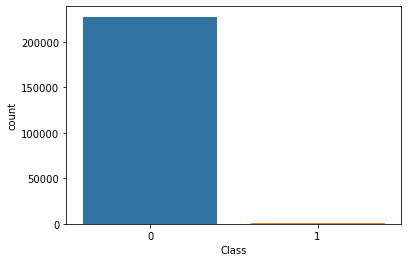

In [2]:
sns.countplot('Class', data=df_train_original)

##### Find out the threshold value for marking or reporting a transaction as fraudulent in your anomaly detection system.
- the AUC score of ANN traing its more than 91 %,which can use as threshold for Anoamly detection.

##### Find out the threshold value for marking or reporting a transaction as fraudulent in your anomaly detection system.

- F1 takes both recall and precission, which make more accurate way to messure perfomance of different modals.
- F1 score for neural network model is better than traditional Machine Learning model.

##### Be as creative as possible in finding other interesting insights.
- The training data contains two days of data, transaction rate day time much more than compare to nights
- The fraudulent transaction had less ammount
- The time and ammount had no correlation in fraudulent transaction